In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [28]:
df = pd.read_csv('../Data/temperature.csv')
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [29]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s, "%Y-%m-%d")

In [30]:
df['Date'] = df.apply(parse_date, axis = 1)

In [31]:
# Get data
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [32]:
# Keep necessary columns only
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [33]:
auckland.set_index(auckland['Date'], inplace = True)
auckland.drop('Date', axis = 1, inplace = True)
auckland.columns = ["AucklandTemp"]
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [34]:
stockholm.set_index(stockholm['Date'], inplace = True)
stockholm.drop('Date', axis = 1, inplace = True)
stockholm.columns = ["StockholmTemp"]
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [35]:
# Join two data
joined = auckland.join(stockholm, how = 'outer') # this will have some missing data
joined.shape

(3155, 2)

<Axes: xlabel='Date'>

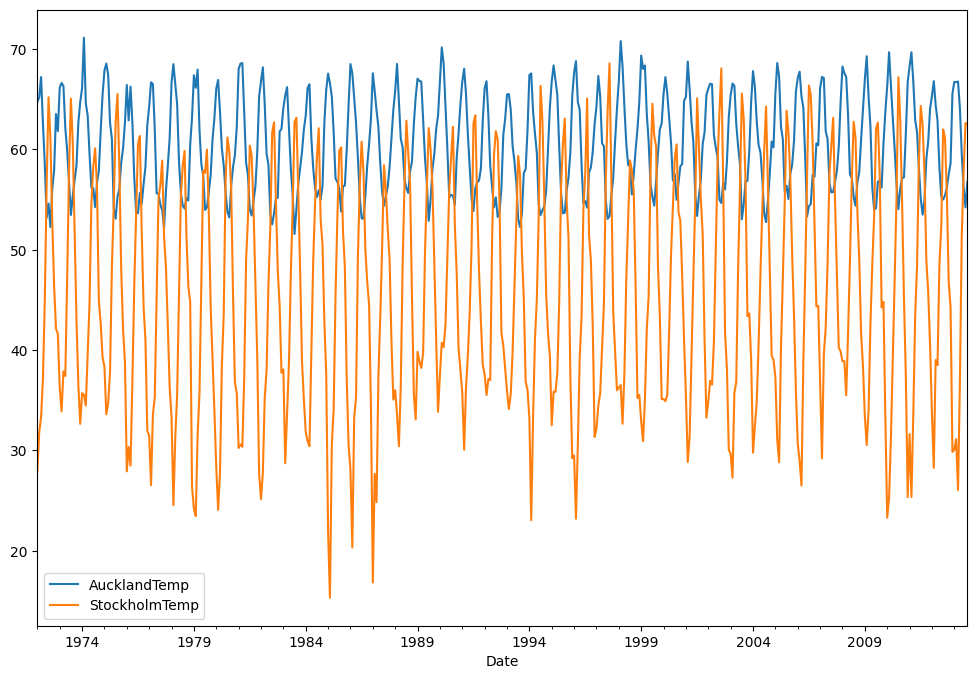

In [40]:
joined_part = joined.iloc[-500:].copy() # use part of the data since it's too much
joined_part.index.freq = 'MS'


joined_part.isna().sum() # Check Missing value

joined_part.interpolate(inplace = True) # interpolate misisng values

joined_part.plot(figsize = (12, 8)) #Data are not in the same scale

In [44]:
# Split train and test
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

# Scale data so that they are in the same scale
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_auckland.fit_transform(train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_auckland.transform(test[['StockholmTemp']])

In [46]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [48]:
# put scaled data in to original df
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

<Axes: xlabel='Date'>

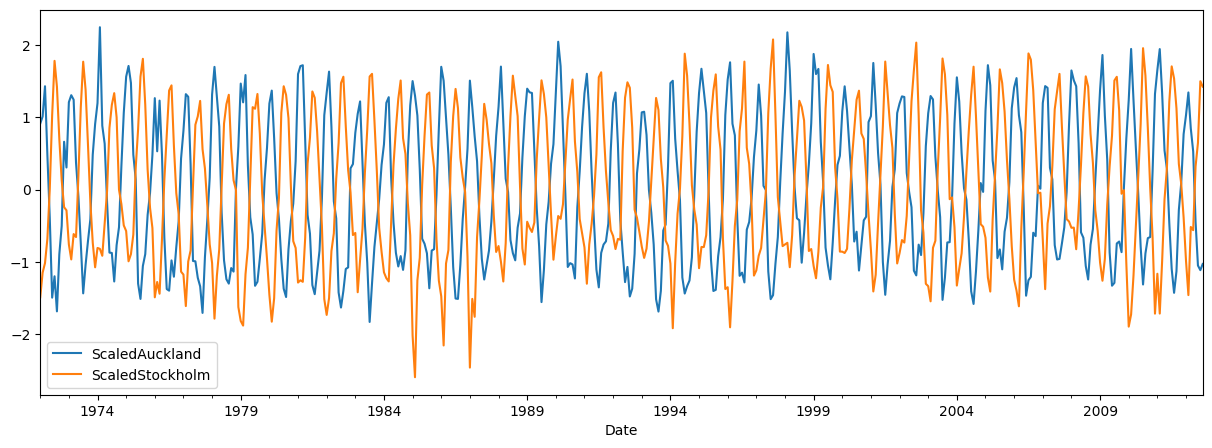

In [49]:
# plot scaled time seris
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot(figsize = (15, 5))

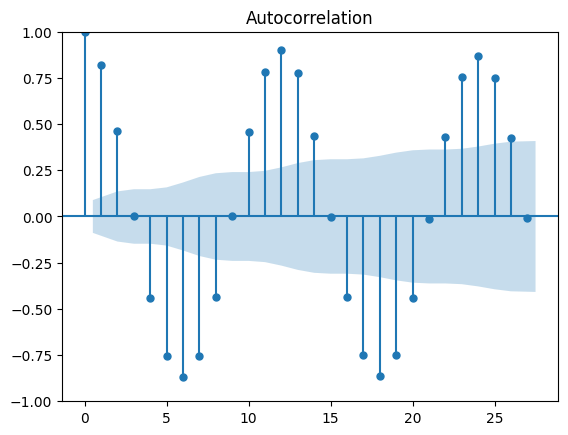

In [52]:
plot_acf(train['ScaledAuckland']); # string seasonal patter 

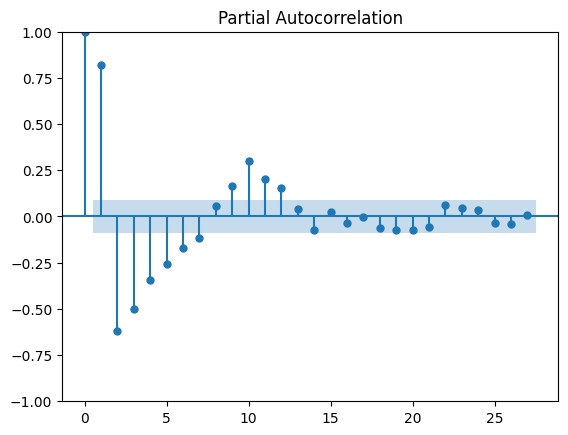

In [53]:
plot_pacf(train['ScaledAuckland']); # string seasonal patter 

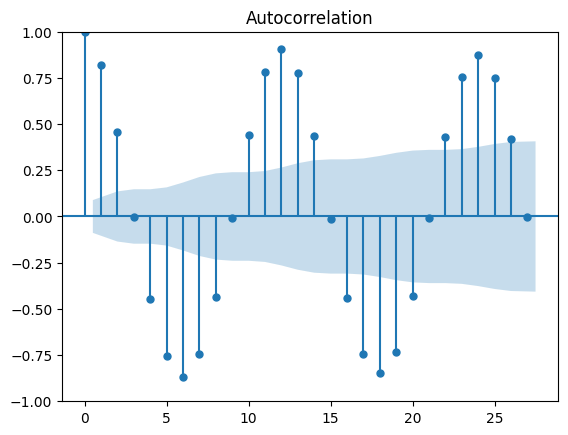

In [54]:
plot_acf(train['ScaledStockholm']); # string seasonal patter 

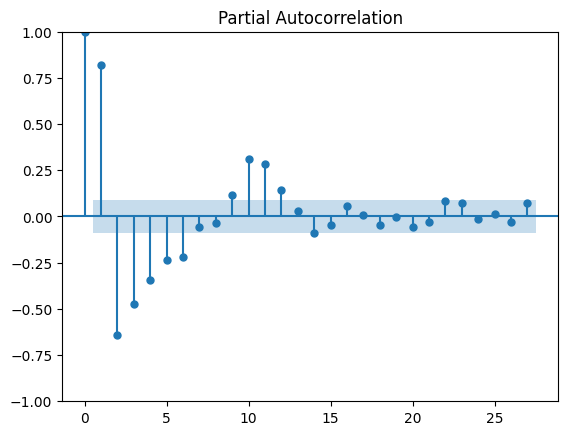

In [55]:
plot_pacf(train['ScaledStockholm']); # string seasonal patter 

# VARMAX

In [57]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter = 100)
print('Duration:', datetime.now() - t0)

/Users/yunjaecho/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           85     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88166D-01    |proj g|=  4.98695D-01

At iterate    5    f=  2.74661D-01    |proj g|=  1.76113D-01

At iterate   10    f=  2.57041D-01    |proj g|=  1.21188D-01

At iterate   15    f=  2.43906D-01    |proj g|=  1.86507D-01

At iterate   20    f=  2.28385D-01    |proj g|=  1.44936D-01

At iterate   25    f=  2.16511D-01    |proj g|=  4.70647D-02

At iterate   30    f=  2.12106D-01    |proj g|=  7.70698D-02

At iterate   35    f=  2.06769D-01    |proj g|=  1.98710D-01

At iterate   40    f=  2.05101D-01    |proj g|=  2.67749D-01

At iterate   45    f=  2.03226D-01    |proj g|=  1.49206D-01

At iterate   50    f=  2.01827D-01    |proj g|=  6.08073D-02

At iterate   55    f=  1.99253D-01    |proj g|=  4.91515D-02

At iterate   60    f=  1.96548D-01    |proj g|=  1.90915D-01

At iterate   65    f=  1.9

/Users/yunjaecho/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:02:20.818864


In [58]:
fcast = res.get_forecast(Ntest)

In [59]:
res.fittedvalues['ScaledStockholm'] # res object already have fitted values

Date
1972-01-01    0.006362
1972-02-01   -1.093530
1972-03-01   -0.729037
1972-04-01   -0.601708
1972-05-01    0.017398
                ...   
2012-04-01   -0.240797
2012-05-01    0.328621
2012-06-01    1.129379
2012-07-01    1.369831
2012-08-01    1.441175
Freq: MS, Name: ScaledStockholm, Length: 488, dtype: float64

<Axes: xlabel='Date'>

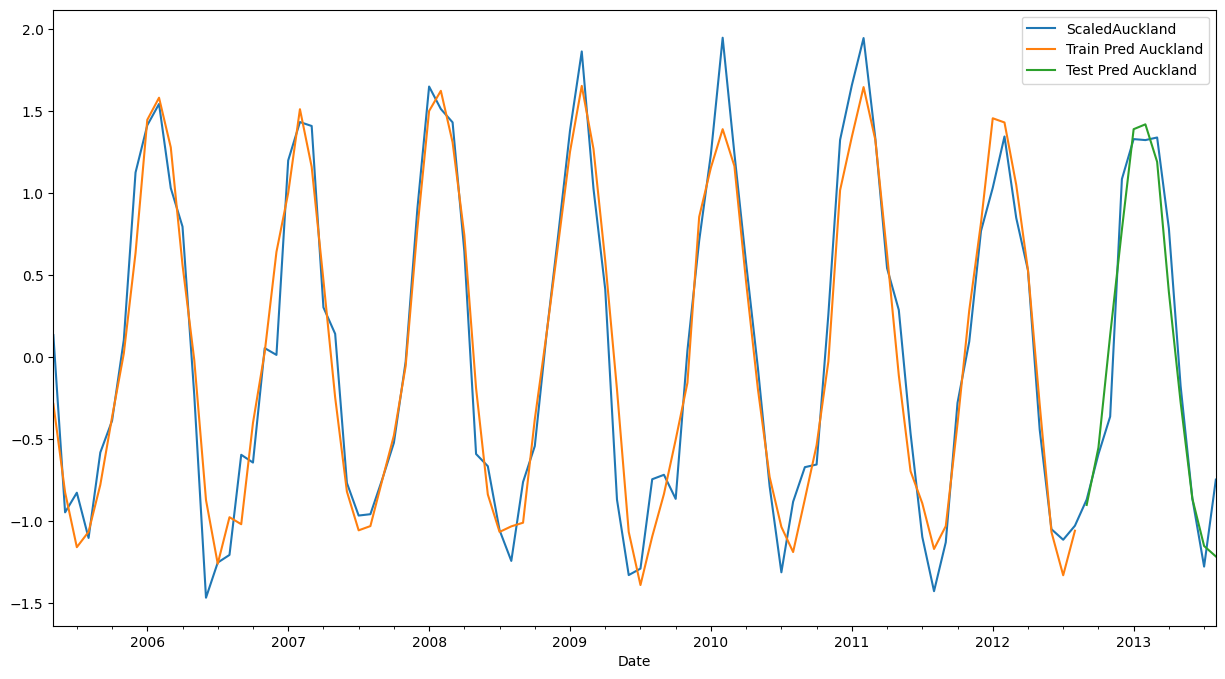

In [64]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland']

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize = (15,8))

<Axes: xlabel='Date'>

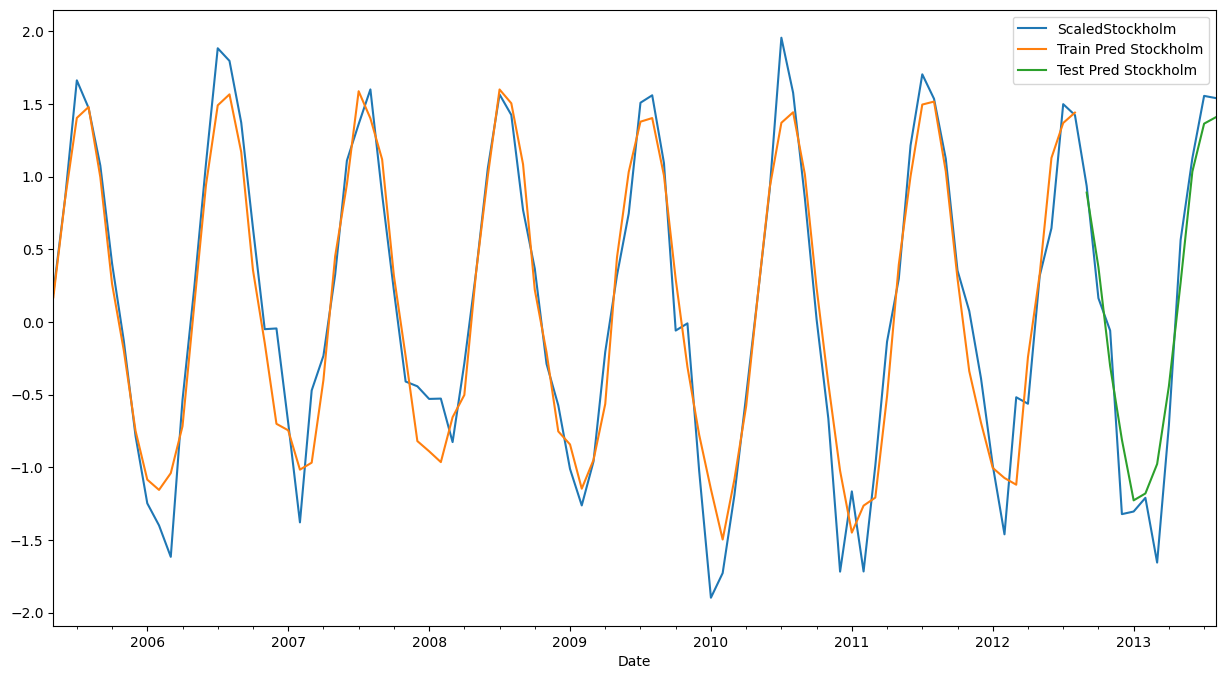

In [65]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize = (15,8))

In [68]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']

print("Auckland Train R^2:", r2_score(y_true, y_pred))


y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']

print("Auckland Test R^2:", r2_score(y_true, y_pred))


Auckland Train R^2: 0.9295499936586125
Auckland Test R^2: 0.9309268050570387


In [69]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']

print("Stockholm Train R^2:", r2_score(y_true, y_pred))


y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']

print("Stockholm Train R^2:", r2_score(y_true, y_pred))


Stockholm Train R^2: 0.9247150399516416
Stockholm Train R^2: 0.9315127093233541


# VAR

In [82]:
model = VAR(train[cols])

lag_order_results = model.select_order(maxlags = 15)

lag_order_results.selected_orders

results = model.fit(maxlags = 15, ic = 'aic') # train model

lag_order = results.k_ar  # AR order

# perfore forecast
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)


<Axes: xlabel='Date'>

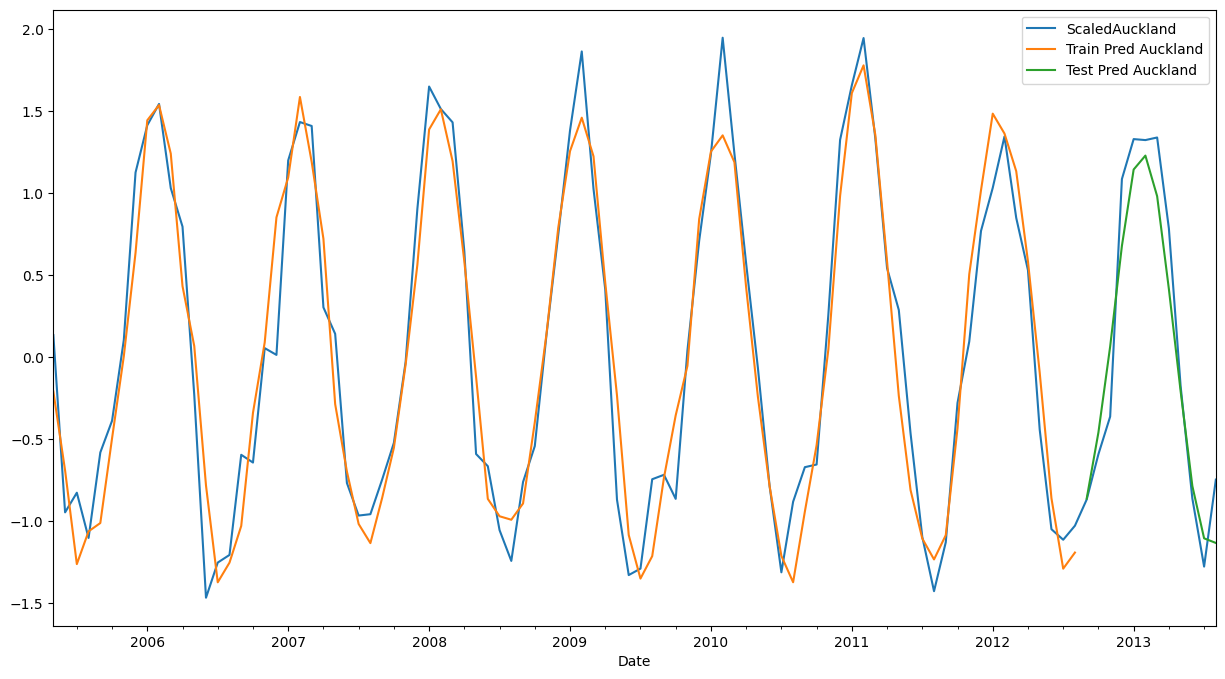

In [83]:
# plot result
joined_part.loc[train_idx, 'Train Pred Auckland'] = results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast[:,0]

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize = (15,8))

<Axes: xlabel='Date'>

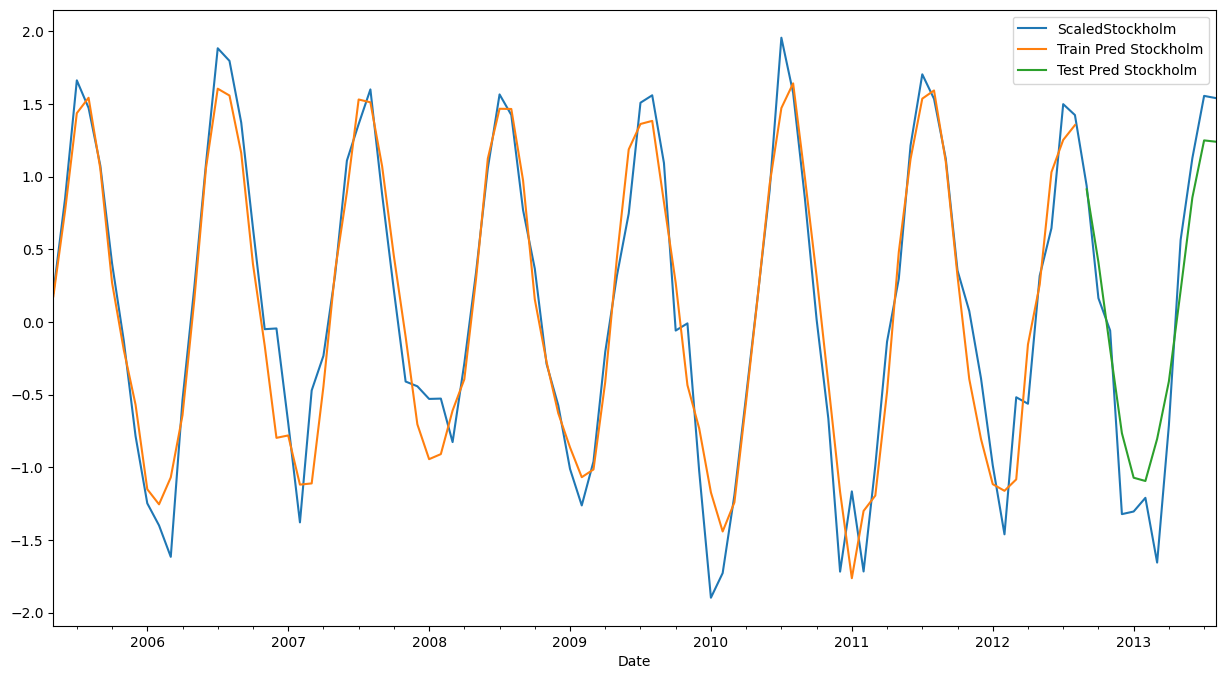

In [93]:
# plot result
joined_part.loc[train_idx, 'Train Pred Stockholm'] = results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize = (15,8))

In [94]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']

y_pred = y_pred.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]

print("Auckland Train R^2:", r2_score(y_true, y_pred))


y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']

print("Auckland Test R^2:", r2_score(y_true, y_pred))


Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340892


In [95]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']

y_pred = y_pred.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]


print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']

print("Stockholm Train R^2:", r2_score(y_true, y_pred))


Stockholm Train R^2: 0.9267030553588321
Stockholm Train R^2: 0.8930437688204873


# ARIMA Baseline

In [96]:
from statsmodels.tsa.arima.model import ARIMA

In [97]:
for col in cols:
    model = ARIMA(train[col], order = (10, 0, 10))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx,col], res.fittedvalues))

    print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx,col], fcast.predicted_mean))

    

/Users/yunjaecho/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213765763526455
ScaledAuckland Test R^2: 0.938080154152215
ScaledStockholm Train R^2: 0.9207342153239624
ScaledStockholm Test R^2: 0.9482860643790507


/Users/yunjaecho/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [100]:
import pmdarima as pm

# seasonal model
for col in cols:
    model = pm.auto_arima(train[col],
                     trace = True,
                     max_q = 10,
                     max_p = 10,
                     max_order = 14,
                     suppress_warnings = True,
                     seasonal = True, m = 12)
    fcast = model.predict(Ntest)
    print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx,col], res.fittedvalues))

    print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx,col], fcast))

    

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=246.861, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1388.884, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=425.658, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=784.586, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1386.884, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=423.016, Time=0.84 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=267.228, Time=2.32 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=253.515, Time=2.48 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=359.039, Time=2.02 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=269.328, Time=3.09 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=210.186, Time=1.14 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=